# Home Composting (HC)

In [1]:
# Import libraries
from swolfpy_processmodels import HC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set font for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "12"

# Set specs for pandas
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)

In [2]:
model = HC()
model.calc()
report=model.report()

In [3]:
model.InputData.Data.iloc[:,:6]

,Category,Dictonary_Name,Parameter Name,Parameter Description,amount,unit
0,Op_param,Op_param,Taod,Annual operating days,260.00000,days/year
1,Op_param,Op_param,comp_cap,composter capacity,2.57000,kg OFMSW/day
2,Degradation parameters,Degradation_param,initMC,Minimum initial moisture content,0.55000,None
3,Degradation parameters,Degradation_param,MCac,Moisture content after active composting,0.50000,None
4,Degradation parameters,Degradation_param,acDegProp,Proportion of mass loss that occurs during active composting,90.00000,%
5,Degradation parameters,Degradation_param,pCasCH4,Proportion of emitted C emitted as CH4,0.01900,None
6,Degradation parameters,Degradation_param,pCasCO,Proportion of emitted C emitted as CO,0.00060,None
7,Degradation parameters,Degradation_param,pNasNH3,Proportion of emitted N emitted as NH3,0.04000,None
8,Degradation parameters,Degradation_param,pNasN2O,Proportion of emitted N emitted as N2O,0.02475,None
9,Material_Properties,Material_Properties,densFC,Density of final compost,700.00000,kg/m3


## Mass balance
* Note: Part of organic wastes are degeraded during the aerobic composting process and emitted to air. So the ratio of products to input waste is smaller than 1.

**Note:** For dry materials, more than 1 Mg leaves the system due to the added wood chips and water.

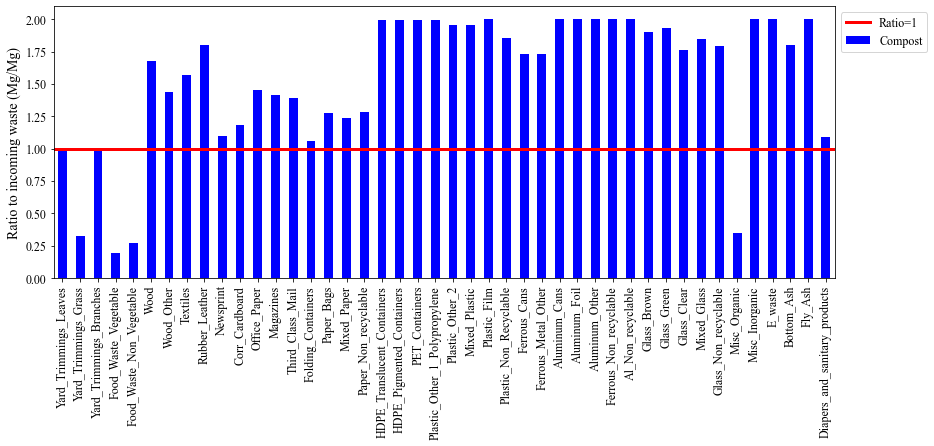

In [4]:
Compost = model.final_compost.data['mass'].values/1000

WasteProductsDf = pd.DataFrame({'Compost': Compost}) 

fig, ax=plt.subplots(figsize=(14, 5))
WasteProductsDf.plot(kind='bar', stacked=True, ax=ax, color=['b','g'])

ax.set_ylabel('Ratio to incoming waste (Mg/Mg)', fontdict={'size':14})
ticks = ax.set_xticklabels(model.Index, rotation=90)
ax.axhline(1, c='r',ls='-', lw=3, label='Ratio=1')
ax.legend(bbox_to_anchor=(1, 1))

## Carbon Balance

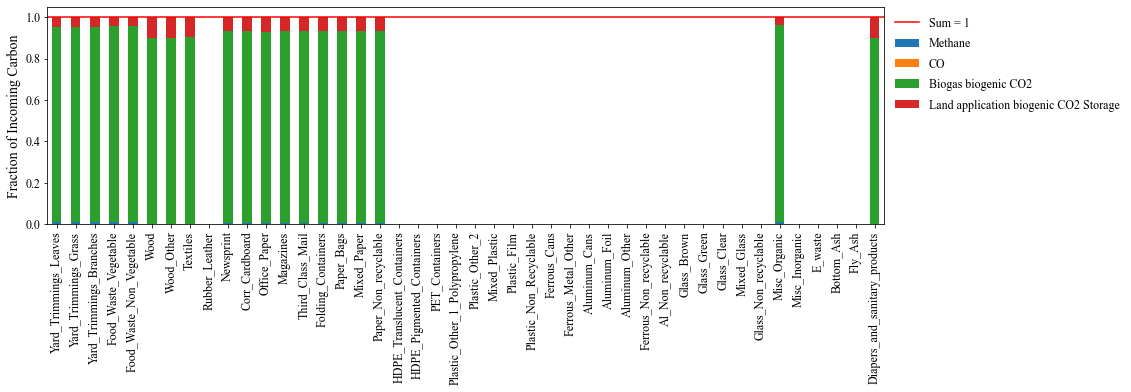

In [5]:
model = HC()
model.InputData.Compost_use['choice_BU']['amount']=1
model.InputData.Compost_use['fertOff']['amount']=1
model.InputData.Compost_use['peatOff']['amount']=1
model.calc()
Income_C = model.input_flow.data['C_cont']
C_CO = model.CommonData.MW['C']['amount']/model.CommonData.MW['CO']['amount']
C_CO2 = model.CommonData.MW['C']['amount']/model.CommonData.MW['CO2']['amount']
C_CH4 = model.CommonData.MW['C']['amount']/model.CommonData.MW['CH4']['amount']

lci_report = model.LCI.report()
C_balance_DF = pd.DataFrame(index=model.Index)


C_balance_DF.loc[:,'Methane'] = lci_report['Methane, non-fossil'] * C_CH4 / Income_C
C_balance_DF.loc[:,'CO'] = lci_report['Carbon monoxide, non-fossil'] * C_CO / Income_C
C_balance_DF.loc[:,'Biogas biogenic CO2'] = lci_report['Carbon dioxide, non-fossil'] * C_CO2 / Income_C
C_balance_DF.loc[:,'Land application biogenic CO2 Storage'] = - lci_report['Direct Carbon Storage and Humus Formation'] * C_CO2 / Income_C

fig, ax=plt.subplots(figsize=(15, 4))
#C_balance_DF.loc[C_balance_DF.sum(axis=1)>0,:].plot(kind='bar', stacked=True, ax=ax)
C_balance_DF.plot(kind='bar', stacked=True, ax=ax)

ax.plot([-0.5,46],[1,1],c='r',label='Sum = 1')
ax.set_ylabel('Fraction of Incoming Carbon',size=14)
legend = ax.legend(frameon=False, labelspacing=0.7, bbox_to_anchor=(1, 1), loc='upper left')

## Nitrogen Balance

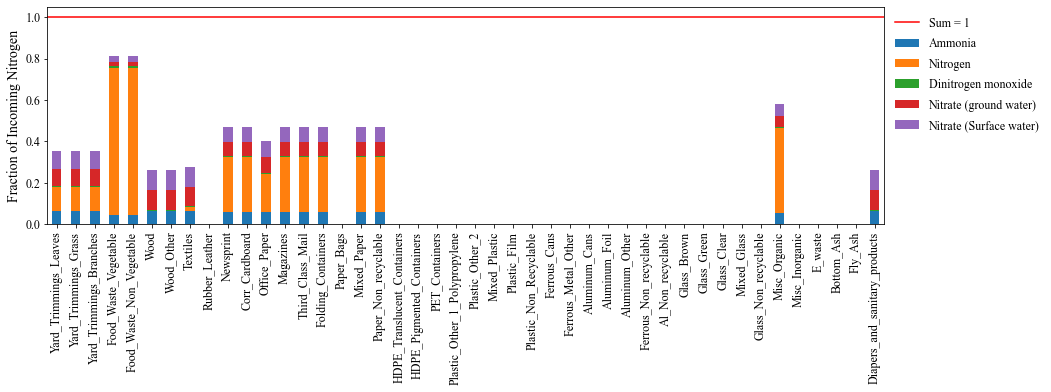

In [6]:
Income_N = model.input_flow.data['N_cont']

N_balance_DF = pd.DataFrame(index=model.Index)

N_NH3 = model.CommonData.MW['N']['amount']/model.CommonData.MW['Ammonia']['amount']
N_N2O = model.CommonData.MW['N']['amount']/model.CommonData.MW['Nitrous_Oxide']['amount']
N_NO3 = model.CommonData.MW['N']['amount']/model.CommonData.MW['Nitrate']['amount']

N_balance_DF.loc[:,'Ammonia'] =  lci_report['Ammonia'] * N_NH3 / Income_N
N_balance_DF.loc[:,'Nitrogen'] =  lci_report['Nitrogen'] / Income_N
N_balance_DF.loc[:,'Dinitrogen monoxide'] =  lci_report['Dinitrogen monoxide'] * N_N2O / Income_N
N_balance_DF.loc[:,'Nitrate (ground water)'] =  lci_report['Nitrate (ground water)'] * N_NO3 / Income_N
N_balance_DF.loc[:,'Nitrate (Surface water)'] =  lci_report['Nitrate (surface water)'] * N_NO3 / Income_N 

fig, ax=plt.subplots(figsize=(15, 4))
N_balance_DF.plot(kind='bar', stacked=True, ax=ax)

ax.plot([-0.5,46],[1,1],c='r',label='Sum = 1')
ax.set_ylabel('Fraction of Incoming Nitrogen',size=14)
legend = ax.legend(frameon=False, labelspacing=0.7, bbox_to_anchor=(1, 1), loc='upper left')